# Task 1
Pipeline that constructs training data based on latitude-longitude coordinates.

- Downloads Open Street Maps files.
- Creates map projections of the contained buildings.
- Downloads satellite images from a Sentinel 2 data provider.

In [1]:
import os

from sentinelhub import (
    CRS,
    BBox,
    bbox_to_dimensions,
    SHConfig,
)
from dotenv import load_dotenv
import imageio.v2 as imageio
import matplotlib.pyplot as plt

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.data_acquisition.sentinel_hub_image_downloader import SentinelHubImageDownloader
from src.data_acquisition.constants import EVALSCRIPTS
from src.data_acquisition.osm import OSM

/home/asicoder/gitrepos/Sentinel-2A-Segmentation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = SHConfig()

load_dotenv(f'{module_path}/.env.local') 

config.sh_client_id = os.getenv("SH_CLIENT_ID")
config.sh_client_secret = os.getenv("SH_CLIENT_SECRET")

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [3]:
# Bounding boxes for Berlin
north = 52.574409
south = 52.454927
east = 13.500205
west = 13.294333

sentinel_bbox = (west, south, east, north)
osmnx_bbox = (north, south, east, west)

# Sentinel Hub API Parameters
resolution = 10
start_date = "2024-04-17"
end_date = "2024-05-17"
evalscripts = EVALSCRIPTS

In [4]:
# Images parameters
imgs_folder = f'{module_path}/imgs'

bbox = BBox(bbox=sentinel_bbox, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: width = {size[0]} px, height = {size[1]} px")

Image shape at 10 m resolution: width = 1426 px, height = 1298 px


### Load buildings from OpenStreetMaps
In order to have the labels for the ML system, we need to download an array containing which pixels are buildings or not.
But first, let's visualize just the buildings of Berlin here.

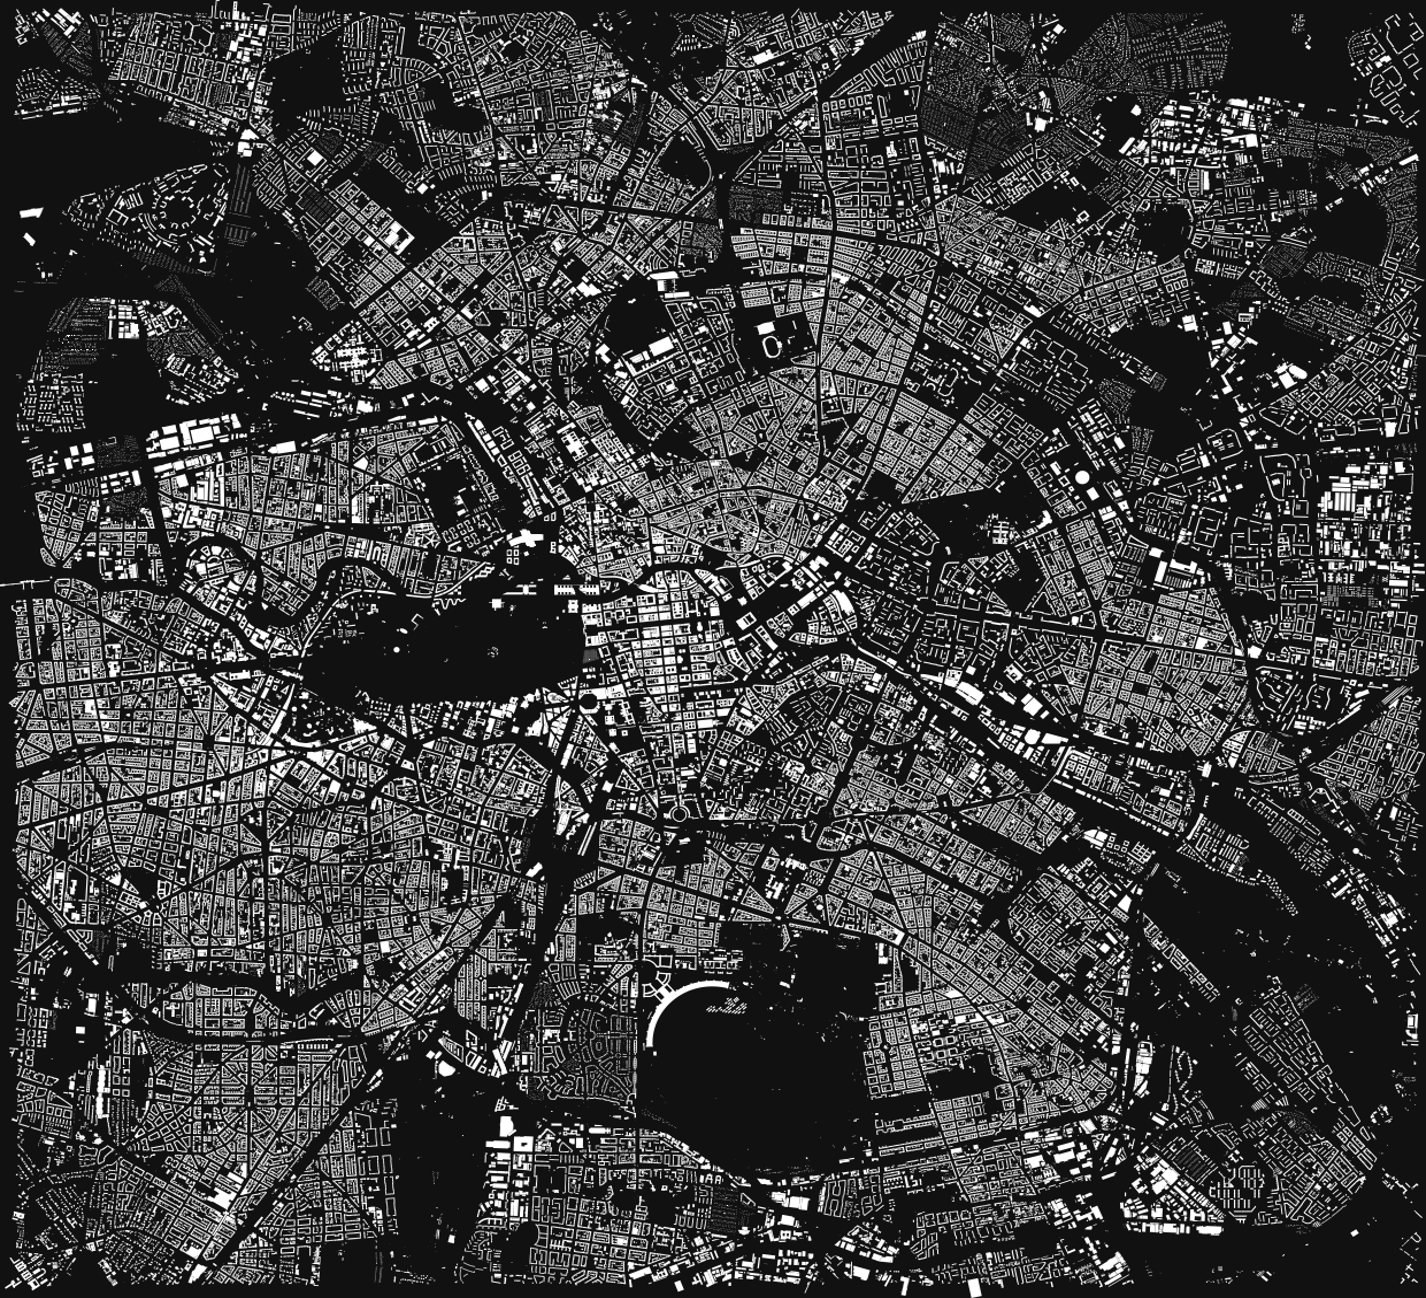

In [5]:
osm = OSM(imgs_folder, 'png')
osm.visualize_buildings(osmnx_bbox, img_name='berlin_buildings_task1_3', dimensions=size)
buildings = osm.buildings(osmnx_bbox, dimensions=size)

### Download and save images from Sentinel Hub API
Download them in RGB, IRB and Grayscale.
For doing so, we have to specify the following parameters:
- Coordinates
- Resolution
- Start and end dates
- Evalscript

We wrap up these API parameters up in our class _SentinelHubImageDownloader_.

In [6]:
downloader = SentinelHubImageDownloader(bbox, size, config, max_cloud_coverage=5)

In [7]:
downloader.time_interval = (start_date, end_date)

RGB image saved as /home/asicoder/gitrepos/Sentinel-2A-Segmentation/imgs/2024-04-17_2024-05-17_10m_RGB.png, showing image...
(1298, 1426, 4)


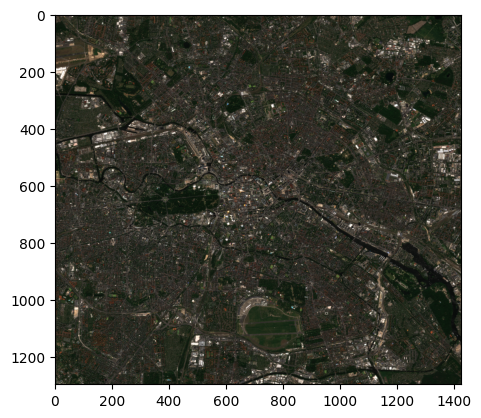

IRB image saved as /home/asicoder/gitrepos/Sentinel-2A-Segmentation/imgs/2024-04-17_2024-05-17_10m_IRB.png, showing image...
(1298, 1426, 4)


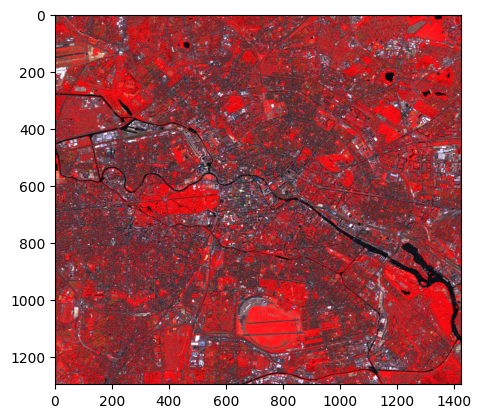

GRAY image saved as /home/asicoder/gitrepos/Sentinel-2A-Segmentation/imgs/2024-04-17_2024-05-17_10m_GRAY.png, showing image...
(1298, 1426)


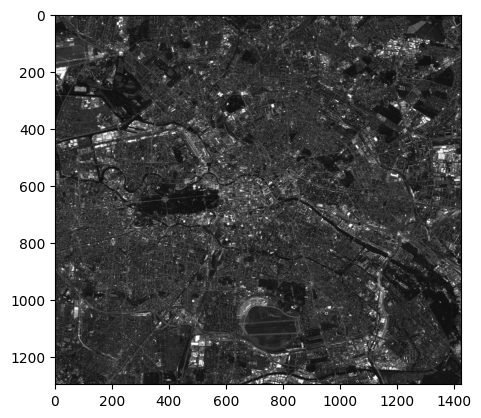

In [8]:
for evalscript_id, evalscript in evalscripts.items():
    downloader.evalscript = evalscript
    image_data = downloader.download_image()
    image_data = image_data[0]
    image_name = f'{imgs_folder}/{start_date}_{end_date}_{resolution}m_{evalscript_id}.png'
    imageio.imsave(image_name, image_data)
    print(f'{evalscript_id} image saved as {image_name}, showing image...')
    #print plot shape
    print(image_data.shape)
    if evalscript_id == 'GRAY':
        plt.imshow(image_data, cmap='gray')
        # Save the image
    else:
        plt.imshow(image_data)
    plt.show()

### Overlapping buildings with RGB

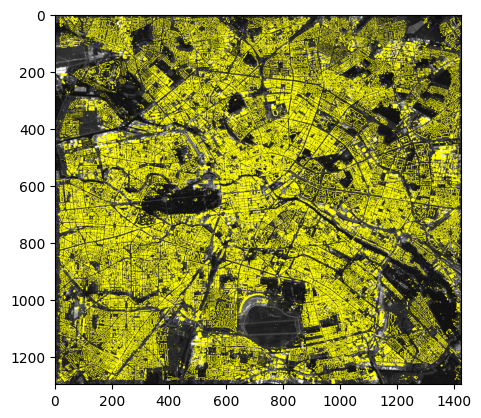

In [9]:
import numpy as np

# read RGB image
image_data = imageio.imread(f'{imgs_folder}/{start_date}_{end_date}_{resolution}m_GRAY.png')
# make it 3D
image_data = np.stack((image_data,)*3, axis=-1)

mask = np.all(buildings == [255, 255, 255], axis=-1)
image_data[mask] = (255, 255, 0)

# show with shape doubled
plt.imshow(image_data)
plt.show()
